In [1]:
import datetime
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
import networkx as nx
import scipy.sparse as sp
from math import log
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import gc
pd.options.display.max_colwidth = 5000
gc.collect()
from IPython.display import display, HTML


In [2]:
posts = pd.read_csv("core_message_posts.csv") 
posts.head()
# gc.collect()

,msg_id,msg_topic_id,msg_date,msg_post,msg_post_key,msg_author_id,msg_ip_address,msg_is_first_post
0,1,1,1316144998,<p>The best first post to make on our forums is the one where you introduce yourself to the community. Check the Introductions forum to do this.</p>,3320f7f06c422ef0fb77342724b4fd24,1,178.140.119.217,1
1,2,2,1316174048,"\n<p>Who are we hosting this forum from?</p>\n<p>I like it a lot, it feels very fluid and the software is very good.</p>\n",9204e4883321af2275a37138d054a3f1,11,109.78.212.13,1
2,3,2,1316183999,"<p>Crisis Host - they basically provide hosting for free speech projects, ergo why they were fine with hosting fascists. And the forum platform I bought from Invision Powe Boards and then installed it myself to the site.</p>",12fd0309239711d02b39127de3502c51,1,178.140.119.217,0
3,4,2,1316186941,"<p>Thank you, I'll make a note of it, I am very impressed by this style of forum, very impressed.</p>",0658c6f99ac18d90609ea074ae5eefe6,11,109.78.212.13,0
4,5,2,1316187178,"<p>If you mean the dark+orange skin then that's a skin I also had to purchase. But if you mean the functionality and etc, then yeah, that's IPB 3.2.2</p>",570257864e3cb812eebc2de5e5919080,1,178.140.119.217,0


In [3]:
topics = pd.read_csv("core_message_topics.csv") 
topics.head()
# gc.collect()

,mt_id,mt_date,mt_title,mt_hasattach,mt_starter_id,mt_start_time,mt_last_post_time,mt_to_count,mt_to_member_id,mt_replies,mt_first_msg_id,mt_is_draft,mt_is_deleted,mt_is_system
0,1,1316144998,Introductions are important,0,1,1316144998,1316144998,1,23,0,1,0,1,0
1,2,1316174048,Our hosts,0,11,1316174047,1316187891,1,1,4,2,0,0,0
2,3,1316223829,Re: Nova Roma,0,16,1316223829,1316224790,1,14,1,7,0,1,0
3,5,1316528414,Introductions are important,0,1,1316528414,1316529737,1,20,1,12,0,1,0
4,6,1316700737,msn,0,1,1316700737,1316701077,1,11,1,14,0,1,0


In [4]:
for i,post in posts.iterrows():
    value=datetime.datetime.fromtimestamp(post["msg_date"])
    posts.loc[i, "msg_date"] = f"{value:%Y-%m-%d %H:%M:%S}"
posts.head()
# gc.collect()



,msg_id,msg_topic_id,msg_date,msg_post,msg_post_key,msg_author_id,msg_ip_address,msg_is_first_post
0,1,1,2011-09-16 09:19:58,<p>The best first post to make on our forums is the one where you introduce yourself to the community. Check the Introductions forum to do this.</p>,3320f7f06c422ef0fb77342724b4fd24,1,178.140.119.217,1
1,2,2,2011-09-16 17:24:08,"\n<p>Who are we hosting this forum from?</p>\n<p>I like it a lot, it feels very fluid and the software is very good.</p>\n",9204e4883321af2275a37138d054a3f1,11,109.78.212.13,1
2,3,2,2011-09-16 20:09:59,"<p>Crisis Host - they basically provide hosting for free speech projects, ergo why they were fine with hosting fascists. And the forum platform I bought from Invision Powe Boards and then installed it myself to the site.</p>",12fd0309239711d02b39127de3502c51,1,178.140.119.217,0
3,4,2,2011-09-16 20:59:01,"<p>Thank you, I'll make a note of it, I am very impressed by this style of forum, very impressed.</p>",0658c6f99ac18d90609ea074ae5eefe6,11,109.78.212.13,0
4,5,2,2011-09-16 21:02:58,"<p>If you mean the dark+orange skin then that's a skin I also had to purchase. But if you mean the functionality and etc, then yeah, that's IPB 3.2.2</p>",570257864e3cb812eebc2de5e5919080,1,178.140.119.217,0


In [5]:
for i,topic in topics.iterrows():
    value = datetime.datetime.fromtimestamp(topic["mt_date"])
    topics.loc[i, "mt_date"] = f"{value:%Y-%m-%d %H:%M:%S}"
    value = datetime.datetime.fromtimestamp(topic["mt_start_time"])
    topics.loc[i, "mt_start_time"] = f"{value:%Y-%m-%d %H:%M:%S}"
    value = datetime.datetime.fromtimestamp(topic["mt_last_post_time"])
    topics.loc[i, "mt_last_post_time"] = f"{value:%Y-%m-%d %H:%M:%S}"
topics.head()
gc.collect()

27

In [6]:
def find_topic(id):
#     print(topics.loc[topics['mt_id'] == id][['mt_title']])
    if (sum(topics.mt_id== id) !=0):
#         print(topics.loc[topics['mt_id'] == id][['mt_title','mt_id']])
        display(HTML(topics.loc[topics['mt_id'] == id][['mt_title','mt_id','mt_starter_id']].to_html()))
        display(HTML(posts.loc[posts['msg_topic_id']==id][['msg_post','msg_author_id']].to_html()))
find_topic(8)

,mt_title,mt_id,mt_starter_id
5,Do you have Skype or AIM or MSN?,8,2


,msg_post,msg_author_id
12,\n<p>My Skype: Gravitorbox</p>\n<p>My AIM: Kacen752</p>\n<p>My MSN: illuminatienlightened@hotmail.com (Also my email)</p>\n,2
13,"<p>I have you on MSN, I'll get on.</p>",8
14,"<p>Evidently you're offline. You have me, I'm eleigios@hotmail.com. You also have me on Facebook, I'm on there at the moment but that's somewhat rare. I get on MSN somewhat randomly, but I'll stay on as long as I can if you'd like to discuss or collaborate.</p>",8
15,"<p>Ah, I kinda wish you had Skype. I don't use MSN as much...come to think of it, was probably stupid I mentioned it.</p>",2
16,"<p>I don't have Skype, but I can Download it and probably should; with all the plans I have that require collaboration it would make my life easier, and it's cheaper than making long-distance phone calls as well. I lent my microphone to a friend recently but I could have it back by tomorrow if you're interested anyway. Just let me know.</p>",8
17,"<p>You should download Skype it is a good service. Also you can use it just like MSN; you can type, I type most of the time.</p>",2
18,"<p>Hmm, I'll get on that right now and then shoot you my username.</p>",8
19,"<p>Roger, mine is Gravitorbox</p>",2


In [7]:
start_date = '2011-01-01'
end_date = '2011-09-25'
posts_2011 = posts[(posts['msg_date']>= start_date) & (posts['msg_date']<= end_date)]
topics_2011 = topics[(topics['mt_date']>= start_date)& (topics['mt_date']<= end_date)]
posts_2011

,msg_id,msg_topic_id,msg_date,msg_post,msg_post_key,msg_author_id,msg_ip_address,msg_is_first_post
0,1,1,2011-09-16 09:19:58,<p>The best first post to make on our forums is the one where you introduce yourself to the community. Check the Introductions forum to do this.</p>,3320f7f06c422ef0fb77342724b4fd24,1,178.140.119.217,1
1,2,2,2011-09-16 17:24:08,"\n<p>Who are we hosting this forum from?</p>\n<p>I like it a lot, it feels very fluid and the software is very good.</p>\n",9204e4883321af2275a37138d054a3f1,11,109.78.212.13,1
2,3,2,2011-09-16 20:09:59,"<p>Crisis Host - they basically provide hosting for free speech projects, ergo why they were fine with hosting fascists. And the forum platform I bought from Invision Powe Boards and then installed it myself to the site.</p>",12fd0309239711d02b39127de3502c51,1,178.140.119.217,0
3,4,2,2011-09-16 20:59:01,"<p>Thank you, I'll make a note of it, I am very impressed by this style of forum, very impressed.</p>",0658c6f99ac18d90609ea074ae5eefe6,11,109.78.212.13,0
4,5,2,2011-09-16 21:02:58,"<p>If you mean the dark+orange skin then that's a skin I also had to purchase. But if you mean the functionality and etc, then yeah, that's IPB 3.2.2</p>",570257864e3cb812eebc2de5e5919080,1,178.140.119.217,0
5,6,2,2011-09-16 21:14:51,"<p>The functionality mostly, thanks for the info.</p>",aabeacc8f4ccc579c405d4248ef2d9d6,11,109.78.212.13,0
6,7,3,2011-09-17 07:13:49,<p>I don't see why one would want to resuscitate Religio Romana.</p>,a36f67c0d722aa8d1d3d9be869616146,16,152.33.69.70,1
7,8,3,2011-09-17 07:29:50,"\n<blockquote data-ipsquote="""" class=""ipsQuote"" data-ipsquote-username=""Talleyrand"" data-cite=""Talleyrand"" data-ipsquote-timestamp=""1316223829"" data-ipsquote-contentapp=""core"" data-ipsquote-contenttype=""messaging"" data-ipsquote-contentid=""3"" data-ipsquote-contentclass=""core_Messenger_Conversation""><div><p>I don't see why one would want to resuscitate Religio Romana.</p></div></blockquote>\n<p>The same reason Reconstructionist paganism thrives today: because they believe in it. I don't mean the brevity to be rude BTW; I just don't know were to go with your question beyond what I've addressed.</p>\n<p>Regards,</p>\n<p>Dux</p>\n",327b933d818a39dc6ac74701015bbc96,14,71.114.56.45,0
8,12,5,2011-09-20 19:50:14,<p>The best first post to make on our forums is the one where you introduce yourself to the community. Check the Introductions forum to do this.</p>,0667258c387129ea0d1108d92be4f9e7,1,178.140.121.11,1
9,13,5,2011-09-20 20:12:17,<p>Done and done. I meant to post something there but i am awfully forgetful sometimes.</p>,de1d7fd2737dd852f5d9c3bf8676c3b9,20,94.103.203.197,0


In [8]:
start_date = '2011-01-01'
end_date = '2012-01-01'
posts_2012 = posts[(posts['msg_date']>= start_date) & (posts['msg_date']<= end_date)]
topics_2012 = topics[(topics['mt_date']>= start_date)& (topics['mt_date']<= end_date)]
gc.collect()

0

In [9]:
cachedStopWords = stopwords.words("english")
def rem_stop_words(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text    
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_str(string):
    string = string.strip().lower()
    string = rem_stop_words(string)
    string = decontracted(string)
    
    string = re.sub(r"<p>", " ", string)
    string = re.sub(r"</p>", " ", string)
    string = re.sub(r"\n", " ", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
#     string = re.sub(r"\'s", " \'s", string)
#     string = re.sub(r"\'ve", " \'ve", string)
#     string = re.sub(r"n\'t", " n\'t", string)
#     string = re.sub(r"\'re", " \'re", string)
#     string = re.sub(r"\'d", " \'d", string)
#     string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
print(clean_str(' I am a boy my name is raj'))

boy name raj


In [10]:
# Document - Word edges: TF-IDF 
# Word- Word edges : PMI
# Author to Document edges: TF- IDF values
def build_graph(posts, topics):
    topic_author={}
    topic_author_count={}
    topic_post_count={}
    topic_post={}
    labels={}
    author_max_id = 0
    num_docs = len(topics.index) 
    max_doc_id = 0
    topic_name_id = {}
    for i, topic in topics.iterrows():
        
        if topic['mt_id'] in topic_post:
            topic_post[topic['mt_id']].append(clean_str(topic['mt_title']))
        else:
            topic_post[topic['mt_id']] = [clean_str(topic['mt_title'])]
        
    for i,post in posts.iterrows():
#         print(i,post)
        author_max_id = max(author_max_id, post['msg_author_id'])
        max_doc_id = max(max_doc_id , post['msg_topic_id'])
        if post['msg_topic_id'] in topic_author:
            topic_author[post['msg_topic_id']].append(post['msg_author_id'])
        else:
            topic_author[post['msg_topic_id']]= [post['msg_author_id']]
        if (post['msg_topic_id'],post['msg_author_id']) in topic_author_count:
            topic_author_count[(post['msg_topic_id'],post['msg_author_id'])] += 1
        else:
            topic_author_count[(post['msg_topic_id'],post['msg_author_id'])] = 1
        if post['msg_topic_id'] in topic_post_count:
            topic_post_count[post['msg_topic_id']] += 1
        else:
            topic_post_count[post['msg_topic_id']]  = 1
#         print(post["msg_topic_id"]) 
        if post['msg_topic_id'] in topic_post:
            topic_post[post['msg_topic_id']].append(clean_str(post['msg_post']))
        else:
            topic_post[post['msg_topic_id']] = [clean_str(post['msg_post'])]
#             topic_post[post['msg_topic_id']] = [post['msg_post']]
    topic_post_count.clear()
# ------------------------------
    word_freq = {}
    word_doc_list = {}
    word_set = set()
    for key in topic_post:
        appeared = set()
        topic_words = topic_post[key]
        for post_words in topic_words:
            words = post_words.split()
            for word in words:
                word_set.add(word)
                if word in word_freq:
                    word_freq[word] += 1
                else:
                    word_freq[word] = 1
                if word in appeared:
                    continue
                if word in word_doc_list:
                    word_doc_list[word].append(key)
                else:
                    word_doc_list[word] = [key]
                appeared.add(word)
    most_freq= [pair[0] for pair in sorted(word_freq.items(), key=lambda item: item[1])]
    most_freq=most_freq[100]
    vocab = list(word_set)
    vocab_size = len(vocab)     
    word_set.clear()
# ------------------------------    
    word_id_map = {}
    for i in range(vocab_size):
        word_id_map[vocab[i]] = i
    word_doc_freq = {}
    for word, doc_list in word_doc_list.items():
        word_doc_freq[word] = len(doc_list)
    word_doc_list.clear()
# ------------------------------
    word_window_freq = {}
    num_window = 0
    for key in topic_post:
        topic_words = topic_post[key]
        for post_words in topic_words:
            appeared = set()
            words = post_words.split()
            num_window+=1
            for word in words:
                if word in appeared:
                    continue
                if word in word_window_freq:
                    word_window_freq[word] += 1
                else:
                    word_window_freq[word] = 1
            appeared.add(word)
            
# ------------------------------ 
    word_pair_count = {}  
    for key in topic_post:
        topic_words = topic_post[key]
        for post_words in topic_words:
            words = post_words.split()
            for i in range(1, len(words)):
                for j in range(0, i):
                    word_i = words[i]
                    word_i_id = word_id_map[word_i]
                    word_j = words [j]
                    word_j_id = word_id_map[word_j]
                    if word_i_id == word_j_id:
                        continue
                    word_pair_str = str(word_i_id) + ',' + str(word_j_id)
                    if word_pair_str in word_pair_count:
                        word_pair_count[word_pair_str] += 1
                    else:
                        word_pair_count[word_pair_str] = 1
                    # two orders
                    word_pair_str = str(word_j_id) + ',' + str(word_i_id)
                    if word_pair_str in word_pair_count:
                        word_pair_count[word_pair_str] += 1
                    else:
                        word_pair_count[word_pair_str] = 1
# ------------------------------   
    row = []
    col = []
    weight = []

# ------------------------------   
    for key in word_pair_count:
        temp = key.split(',')
        #my, name 2
        i = int(temp[0])
        j = int(temp[1])
        count = word_pair_count[key]#2
        word_freq_i = word_window_freq[vocab[i]]# number of windows  my occurs
        word_freq_j = word_window_freq[vocab[j]]
        pmi = log((1.0 * count / num_window) /
                  (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
        if pmi <= 0:
            continue
        row.append(i)
        col.append(j)
        weight.append(pmi)
    for i in vocab:
        labels[word_id_map[i]]=str(i)
    word_window_freq.clear()
    word_pair_count.clear()
# ------------------------------
    doc_word_freq = {}
    #{(document_id,word_id), frequency}
    for key in topic_post:
        topic_words = topic_post[key]
        for post_words in topic_words:
            words = post_words.split()
            for word in words:
                word_id = word_id_map[word]
                doc_word_str = str(key) + ',' + str(word_id)
                if doc_word_str in doc_word_freq:
                    doc_word_freq[doc_word_str] += 1
                else:
                    doc_word_freq[doc_word_str] = 1
# ------------------------------
    
    for key in topic_post:
        topic_words = topic_post[key]
        doc_word_set = set()
        for post_words in topic_words:
            words = post_words.split()
            for word in words:
                if word in doc_word_set:
                    continue
                j = word_id_map[word]
                key1 = str(key) + ',' + str(j)# document_id, word_id
                freq = doc_word_freq[key1]
                row.append(vocab_size + key)
                col.append(j)
                idf = log(1.0 * num_docs /
                          word_doc_freq[vocab[j]])
                weight.append(freq * idf)
                doc_word_set.add(word)
    for i,topic in topics.iterrows():
        labels[vocab_size + i] = topic['mt_title']
    word_freq.clear()
    doc_word_freq.clear()
# ------------------------------
    author_topic_freq = {}
    for key in topic_author:
        for auth in topic_author[key]:
            if auth in author_topic_freq:
                author_topic_freq[auth] += 1
            else:
                author_topic_freq[auth] = 1
                
    for key in topic_author_count:
        topic_id = key[0]
        author_id = key[1]
        num_post = len(topic_post[topic_id])
        freq = topic_author_count[key]
        idf = log(1.0 * num_docs / author_topic_freq[author_id] )
        row.append(vocab_size + topic_id)
        col.append(vocab_size + num_docs + author_id)
        labels[vocab_size + num_docs + author_id] = 'author_' + str(author_id)
        weight.append(freq*idf)
    author_topic_freq.clear()
# ------------------------------
    topic_post.clear()
    topic_author.clear()
    topic_author_count.clear()
#     print(author_max_id, max_doc_id , vocab_size, num_docs )
    for i in range(author_max_id):
        labels[vocab_size + max_doc_id + i] = 'author_' + str(i)
    node_size = vocab_size + max_doc_id  + author_max_id
    for i in range(node_size):
        if i not in labels:
            labels[i]='label'
#     a=[]
#     for i in weight:
#             a.append(i)
    adj = sp.csr_matrix(
        (weight, (row, col)), shape=(node_size, node_size))
#     G = nx.Graph()
    features = sp.identity(node_size) 
    G = nx.from_scipy_sparse_matrix(adj)
    temp = np.identity(node_size, dtype = float) 
    
#     summation_weight= sum(weight)
#     adj_1 = np.zeros(temp.shape)
#     a =  (-1)  / (node_size * node_size  - len(row)) 
#     adj_1[adj_1 > -1] = -a
    
#     for i in range(len(row)):
#         adj_1[row[i]][col[i]] = weight[i]
    return G,labels,vocab_size, max_doc_id, author_max_id, adj, features, node_size
# gc.collect()

In [11]:
a, node_names, vocab_size, max_doc_id, author_max_id, adj, features, node_size = build_graph(posts_2011, topics_2011)
# a, labels, vocab_size,adj=build_graph(posts_2012, topics_2012)
adj

<263x263 sparse matrix of type '<class 'numpy.float64'>'
	with 6706 stored elements in Compressed Sparse Row format>

In [12]:
a1, node_names1, vocab_size1, max_doc_id1, author_max_id1, adj1, features1, node_size1 = build_graph(posts_2012, topics_2012)                  
# a, labels, vocab_size,adj=build_graph(posts_2012, topics_2012)
adj1

<2935x2935 sparse matrix of type '<class 'numpy.float64'>'
	with 405338 stored elements in Compressed Sparse Row format>

In [13]:
emb1= []

In [14]:
# print(node_names, node_names1)

/home/raj/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


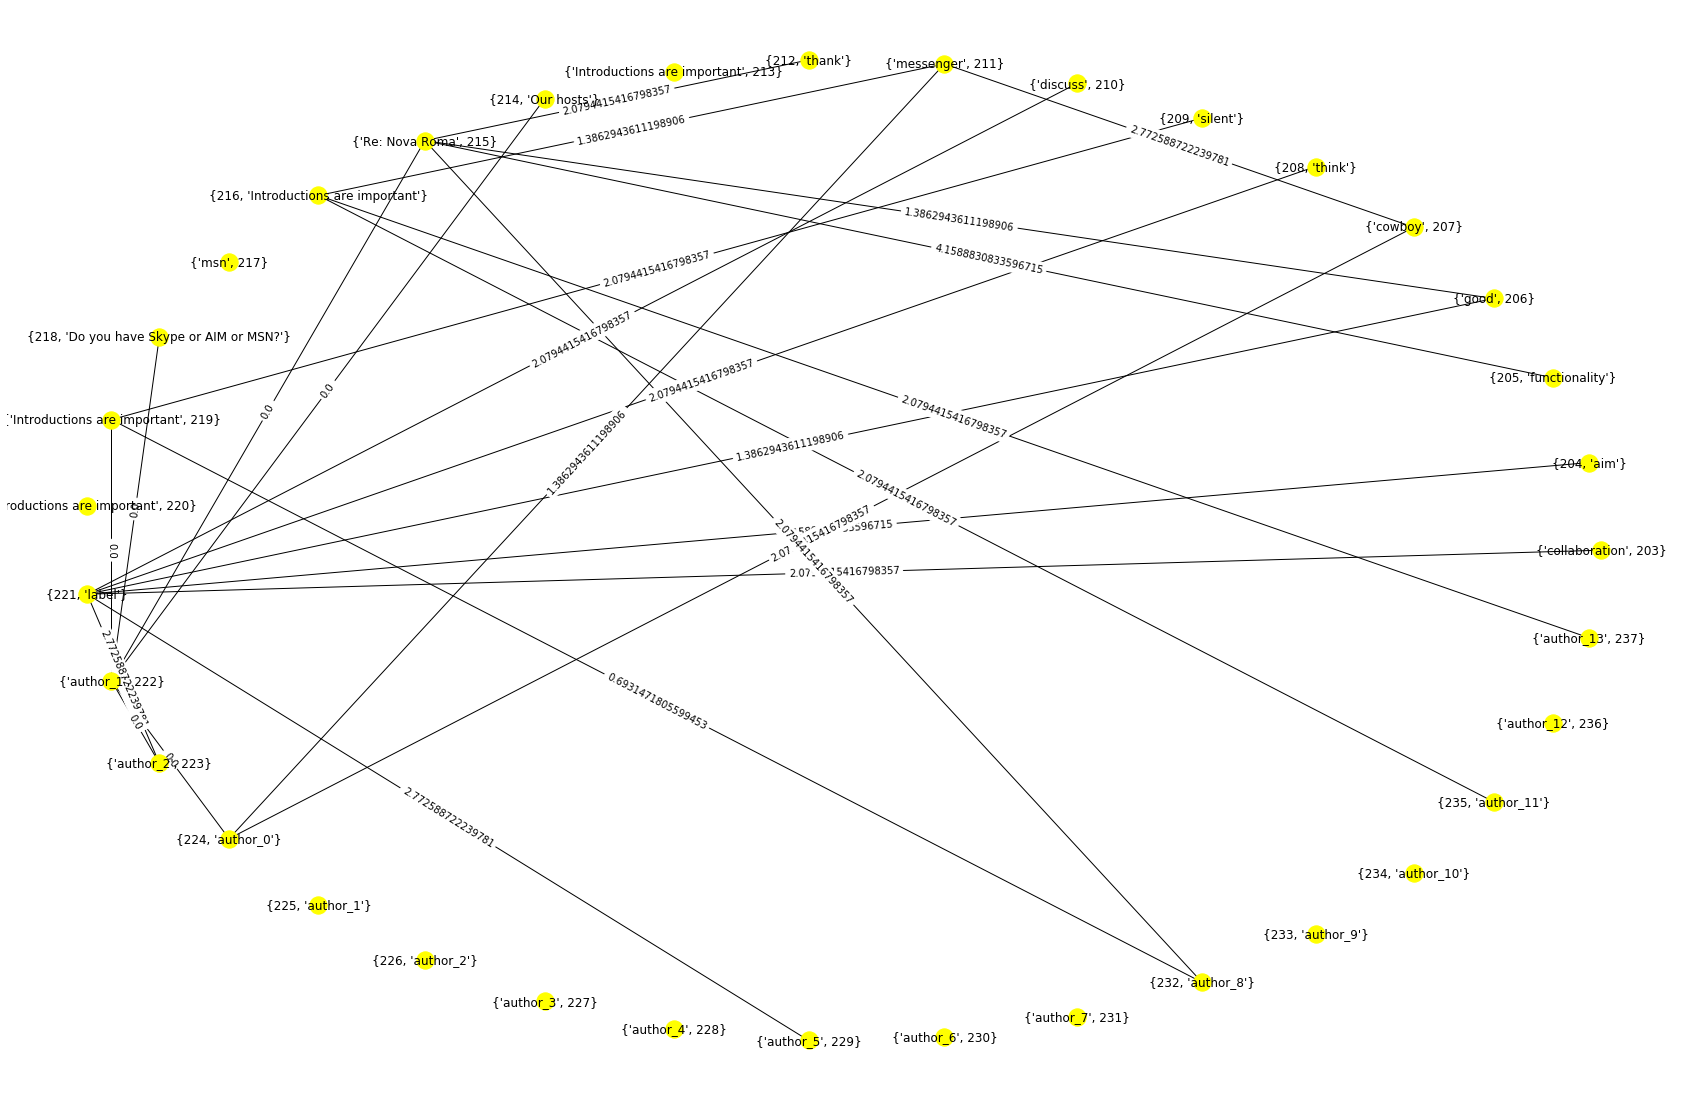

5380

In [15]:
plt.figure(figsize=(30,20))
# l = [*range(vocab_size1+max_doc_id1,vocab_size1+max_doc_id1+35)]
l = [*range(vocab_size - 10, vocab_size + 25)]
label_1 = {}
for i in l:
    label_1[i] = {node_names[i], i}
b = a.subgraph(l)
pos = nx.circular_layout(b)

# pos = nx.spring_layout(b)
l1 = nx.get_edge_attributes(b,'weight')
nx.draw_networkx_edge_labels(b,pos,edge_labels=l1)
nx.draw_circular(b, with_labels= True, labels= label_1, node_color= 'yellow')
plt.savefig("Graph.eps", format="eps")
plt.show()
gc.collect()
# 2904 * 2904 feature matrix 2704 of nodes are words

In [16]:
 
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from optimizer import OptimizerAE, OptimizerVAE
from input_data import load_data
from model import GCNModelAE, GCNModelVAE
from preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

# Settings
flags = tf.compat.v1.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.05, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 8, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
flags.DEFINE_string('dataset', 'bitcoin', 'Dataset string.')
flags.DEFINE_integer('features', 0, 'Whether to use features (1) or not (0).')
flags.DEFINE_string('f', '', 'kernel')
model_str = FLAGS.model
dataset_str = FLAGS.dataset

In [17]:
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

tf.compat.v1.disable_eager_execution()
# Define placeholders
placeholders = {
    'features': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj_orig': tf.compat.v1.sparse_placeholder(tf.float32),
    'dropout': tf.compat.v1.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

(263, 263)


In [18]:

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# adj_orig= adj#Please comment, this is a test 
cost_val = []
acc_val = []

x =[]
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        [emb, emb1] = sess.run([model.z_mean, model.reconstructions], feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

#     print(len(emb1))
    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)

#     adj_rec = np.reshape(emb1, (-1, len(emb)))
#     adj_rec = emb
#     print(adj_orig, adj_rec)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy, model.z], feed_dict=feed_dict)
#     outs = sess.run([opt.opt_op, opt.cost, opt.accuracy, model.embeddings], feed_dict=feed_dict)
    embeddings = outs[3]
    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
#     roc_curr_train, ap_curr_train = get_roc_score(train_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))
    x = embeddings
print("Optimization Finished!")


emb1.append(x)

W1202 17:23:02.696079 140184084436800 module_wrapper.py:139] From /home/raj/Desktop/cs4-1/iron_march/model.py:31: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1202 17:23:02.699178 140184084436800 module_wrapper.py:139] From /home/raj/anaconda3/lib/python3.7/site-packages/gae-0.0.1-py3.7.egg/gae/initializations.py:9: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1202 17:23:02.730436 140184084436800 module_wrapper.py:139] From /home/raj/Desktop/cs4-1/iron_march/layers.py:29: The name tf.sparse_retain is deprecated. Please use tf.sparse.retain instead.

W1202 17:23:02.744443 140184084436800 module_wrapper.py:139] From /home/raj/Desktop/cs4-1/iron_march/layers.py:101: The name tf.sparse_tensor_dense_matmul is deprecated. Please use tf.sparse.sparse_dense_matmul instead.

W1202 17:23:02.763464 140184084436800 deprecation.py:506] From /home/raj/Desktop/cs4-1/iron_march/layers.py:79: calling dropout (from tenso

Epoch: 0001 train_loss= 1.32249 train_acc= 0.50219 val_roc= 0.50879 val_ap= 0.55279 time= 0.31326
Epoch: 0002 train_loss= 1.24118 train_acc= 0.49806 val_roc= 0.52637 val_ap= 0.52987 time= 0.02638
Epoch: 0003 train_loss= 1.14867 train_acc= 0.49791 val_roc= 0.55957 val_ap= 0.54411 time= 0.02360
Epoch: 0004 train_loss= 1.04565 train_acc= 0.49268 val_roc= 0.53906 val_ap= 0.56088 time= 0.02267
Epoch: 0005 train_loss= 0.97913 train_acc= 0.48981 val_roc= 0.57715 val_ap= 0.56387 time= 0.02272
Epoch: 0006 train_loss= 0.93236 train_acc= 0.48958 val_roc= 0.55566 val_ap= 0.57536 time= 0.02195
Epoch: 0007 train_loss= 0.87624 train_acc= 0.48736 val_roc= 0.54590 val_ap= 0.58889 time= 0.02311
Epoch: 0008 train_loss= 0.88155 train_acc= 0.45769 val_roc= 0.57520 val_ap= 0.59991 time= 0.02461
Epoch: 0009 train_loss= 0.88543 train_acc= 0.45737 val_roc= 0.68652 val_ap= 0.64690 time= 0.02571
Epoch: 0010 train_loss= 0.89302 train_acc= 0.46209 val_roc= 0.67871 val_ap= 0.61470 time= 0.03274
Epoch: 0011 train_lo

Epoch: 0087 train_loss= 0.65240 train_acc= 0.53784 val_roc= 0.88770 val_ap= 0.87440 time= 0.03308
Epoch: 0088 train_loss= 0.65626 train_acc= 0.53995 val_roc= 0.88867 val_ap= 0.87590 time= 0.02726
Epoch: 0089 train_loss= 0.66317 train_acc= 0.54354 val_roc= 0.88672 val_ap= 0.87379 time= 0.02770
Epoch: 0090 train_loss= 0.67699 train_acc= 0.54068 val_roc= 0.88477 val_ap= 0.87205 time= 0.02571
Epoch: 0091 train_loss= 0.63193 train_acc= 0.54721 val_roc= 0.88477 val_ap= 0.87122 time= 0.03141
Epoch: 0092 train_loss= 0.67432 train_acc= 0.53547 val_roc= 0.88770 val_ap= 0.87397 time= 0.02874
Epoch: 0093 train_loss= 0.65856 train_acc= 0.54828 val_roc= 0.89062 val_ap= 0.87381 time= 0.02609
Epoch: 0094 train_loss= 0.65693 train_acc= 0.54299 val_roc= 0.88965 val_ap= 0.87312 time= 0.02719
Epoch: 0095 train_loss= 0.65058 train_acc= 0.54296 val_roc= 0.88867 val_ap= 0.87269 time= 0.03523
Epoch: 0096 train_loss= 0.66780 train_acc= 0.54672 val_roc= 0.88965 val_ap= 0.88014 time= 0.02990
Epoch: 0097 train_lo

Epoch: 0173 train_loss= 0.62243 train_acc= 0.56760 val_roc= 0.91113 val_ap= 0.90793 time= 0.03071
Epoch: 0174 train_loss= 0.63696 train_acc= 0.57011 val_roc= 0.91016 val_ap= 0.90683 time= 0.02606
Epoch: 0175 train_loss= 0.59059 train_acc= 0.56019 val_roc= 0.90918 val_ap= 0.90460 time= 0.02795
Epoch: 0176 train_loss= 0.60599 train_acc= 0.56346 val_roc= 0.91211 val_ap= 0.90916 time= 0.02753
Epoch: 0177 train_loss= 0.60007 train_acc= 0.56739 val_roc= 0.91309 val_ap= 0.91094 time= 0.02655
Epoch: 0178 train_loss= 0.59937 train_acc= 0.55557 val_roc= 0.91211 val_ap= 0.90985 time= 0.02803
Epoch: 0179 train_loss= 0.59472 train_acc= 0.56462 val_roc= 0.91211 val_ap= 0.91173 time= 0.02926
Epoch: 0180 train_loss= 0.57844 train_acc= 0.56505 val_roc= 0.91113 val_ap= 0.91058 time= 0.02547
Epoch: 0181 train_loss= 0.60022 train_acc= 0.55690 val_roc= 0.90527 val_ap= 0.90556 time= 0.02852
Epoch: 0182 train_loss= 0.60025 train_acc= 0.56395 val_roc= 0.90723 val_ap= 0.90686 time= 0.02789
Epoch: 0183 train_lo

In [19]:
adj_orig = adj1
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj1)
adj1 = adj_train

if FLAGS.features == 0:
    features = sp.identity(features1.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj1)
adj = adj1
tf.compat.v1.disable_eager_execution()
# Define placeholders
placeholders = {
    'features': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj': tf.compat.v1.sparse_placeholder(tf.float32),
    'adj_orig': tf.compat.v1.sparse_placeholder(tf.float32),
    'dropout': tf.compat.v1.placeholder_with_default(0., shape=())
}

num_nodes = adj1.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# adj_orig= adj#Please comment, this is a test 
cost_val = []
acc_val = []

x =[]
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        [emb, emb1] = sess.run([model.z_mean, model.reconstructions], feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

#     print(len(emb1))
    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)

#     adj_rec = np.reshape(emb1, (-1, len(emb)))
#     adj_rec = emb
#     print(adj_orig, adj_rec)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy, model.z], feed_dict=feed_dict)
#     outs = sess.run([opt.opt_op, opt.cost, opt.accuracy, model.embeddings], feed_dict=feed_dict)
    embeddings = outs[3]
    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
#     roc_curr_train, ap_curr_train = get_roc_score(train_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))
    x = embeddings
print("Optimization Finished!")


emb1.append(x)

(2935, 2935)
Epoch: 0001 train_loss= 1.30035 train_acc= 0.50035 val_roc= 0.55524 val_ap= 0.56491 time= 7.15940
Epoch: 0002 train_loss= 1.23093 train_acc= 0.49397 val_roc= 0.54474 val_ap= 0.55323 time= 0.69625
Epoch: 0003 train_loss= 1.14475 train_acc= 0.49259 val_roc= 0.56504 val_ap= 0.56326 time= 0.69664
Epoch: 0004 train_loss= 1.07669 train_acc= 0.49103 val_roc= 0.58037 val_ap= 0.57625 time= 2.15615
Epoch: 0005 train_loss= 1.03199 train_acc= 0.48572 val_roc= 0.58261 val_ap= 0.57955 time= 0.65638
Epoch: 0006 train_loss= 0.96330 train_acc= 0.48323 val_roc= 0.55636 val_ap= 0.55953 time= 0.80814
Epoch: 0007 train_loss= 0.94446 train_acc= 0.48089 val_roc= 0.54020 val_ap= 0.54551 time= 0.82760
Epoch: 0008 train_loss= 0.89761 train_acc= 0.48076 val_roc= 0.54934 val_ap= 0.55359 time= 0.75087
Epoch: 0009 train_loss= 0.89365 train_acc= 0.47295 val_roc= 0.57742 val_ap= 0.57297 time= 0.75340
Epoch: 0010 train_loss= 0.87373 train_acc= 0.47574 val_roc= 0.59699 val_ap= 0.58859 time= 0.70654
Epoch: 

Epoch: 0085 train_loss= 0.69198 train_acc= 0.41316 val_roc= 0.75576 val_ap= 0.76144 time= 0.69533
Epoch: 0086 train_loss= 0.68959 train_acc= 0.41666 val_roc= 0.75581 val_ap= 0.76305 time= 0.69360
Epoch: 0087 train_loss= 0.68824 train_acc= 0.41435 val_roc= 0.75497 val_ap= 0.76306 time= 0.71913
Epoch: 0088 train_loss= 0.68336 train_acc= 0.41066 val_roc= 0.75742 val_ap= 0.76451 time= 0.72945
Epoch: 0089 train_loss= 0.68643 train_acc= 0.41354 val_roc= 0.76012 val_ap= 0.76582 time= 0.71749
Epoch: 0090 train_loss= 0.67735 train_acc= 0.41073 val_roc= 0.76001 val_ap= 0.76741 time= 0.69578
Epoch: 0091 train_loss= 0.68394 train_acc= 0.40996 val_roc= 0.76127 val_ap= 0.76854 time= 0.67837
Epoch: 0092 train_loss= 0.68527 train_acc= 0.41156 val_roc= 0.76296 val_ap= 0.76886 time= 0.69793
Epoch: 0093 train_loss= 0.68024 train_acc= 0.42715 val_roc= 0.76390 val_ap= 0.77156 time= 0.76144
Epoch: 0094 train_loss= 0.68399 train_acc= 0.41902 val_roc= 0.76368 val_ap= 0.77210 time= 0.68842
Epoch: 0095 train_lo

Epoch: 0169 train_loss= 0.63582 train_acc= 0.41468 val_roc= 0.80375 val_ap= 0.80970 time= 0.97932
Epoch: 0170 train_loss= 0.64138 train_acc= 0.42251 val_roc= 0.80385 val_ap= 0.81069 time= 1.03661
Epoch: 0171 train_loss= 0.64065 train_acc= 0.41851 val_roc= 0.80382 val_ap= 0.81089 time= 0.99230
Epoch: 0172 train_loss= 0.63966 train_acc= 0.42029 val_roc= 0.80355 val_ap= 0.81026 time= 0.95270
Epoch: 0173 train_loss= 0.64142 train_acc= 0.41977 val_roc= 0.80402 val_ap= 0.81115 time= 0.91604
Epoch: 0174 train_loss= 0.63622 train_acc= 0.41800 val_roc= 0.80446 val_ap= 0.81185 time= 1.03672
Epoch: 0175 train_loss= 0.64156 train_acc= 0.41114 val_roc= 0.80475 val_ap= 0.81164 time= 0.82619
Epoch: 0176 train_loss= 0.63764 train_acc= 0.41832 val_roc= 0.80516 val_ap= 0.81233 time= 0.94611
Epoch: 0177 train_loss= 0.64290 train_acc= 0.42123 val_roc= 0.80524 val_ap= 0.81272 time= 0.78849
Epoch: 0178 train_loss= 0.63478 train_acc= 0.41804 val_roc= 0.80522 val_ap= 0.81265 time= 0.98697
Epoch: 0179 train_lo

W1202 17:26:34.592424 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 17:26:34.593375 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


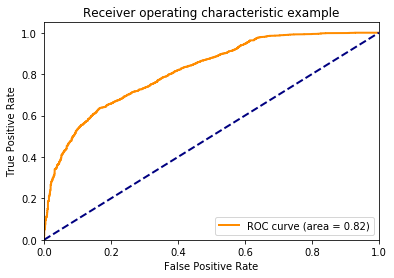

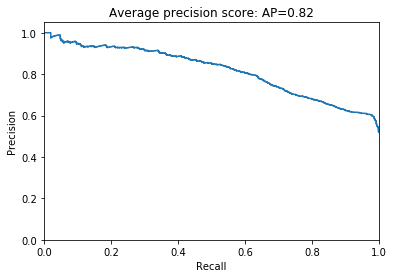

Test ROC score: 0.816449394162097
Test AP score: 0.8175610651062214


In [20]:

def get_roc_score_test(edges_pos, edges_neg, emb=None):
    from sklearn.metrics import roc_curve, auc
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        [emb, emb1] = sess.run([model.z_mean, model.reconstructions], feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

#     print(len(emb1))
    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)

#     adj_rec = np.reshape(emb1, (-1, len(emb)))
#     adj_rec = emb
#     print(adj_orig, adj_rec)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    preds_all = np.nan_to_num(preds_all)  
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_all, preds_all)
    from sklearn.metrics import precision_recall_curve
    precision = dict()
    recall = dict()
    
    precision["micro"], recall["micro"], _ = precision_recall_curve(labels_all,
    preds_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
#     plt.axis('square')
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_iron_march.eps')
    
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score: AP={0:0.2f}'
        .format(ap_score))
    plt.savefig('ap_curve_iron_march.eps')
    plt.show()
    return roc_score, ap_score
roc_score, ap_score = get_roc_score_test(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

In [21]:
len(emb1[0])

263

In [22]:
def diac(old, new, old_nodes, new_nodes):
    name_num_old={}
    name_num_new={}
    for key in old_nodes:
        name_num_old[old_nodes[key]] = key
    for key in new_nodes:
        name_num_new[new_nodes[key]] = key
    new_graph = []
    for i in range(len(old)):
        a = old_nodes[i]
#         print(a)
        b = name_num_new[a]
        new_graph.append(new[b])
#     print(len(new_graph), len(old), len(old[0]), len(new_graph[0]))
    from scipy.linalg import orthogonal_procrustes
    R = orthogonal_procrustes(new_graph, old)
#     print(len(R),len(R[0]),len(R[0][0]))
#     print(R[1])
    Ex= np.dot(R[0],np.transpose(new_graph))
    from sklearn.metrics.pairwise import cosine_similarity
    print(len (Ex.T), len(Ex.T[0]))
    Ans = cosine_similarity(old, Ex.T, dense_output=True)
    print(len(Ans), len(Ans[0]))
    E= np.dot(R[0],new.T)
    return E.T, Ans
    

In [23]:
emb_new, cosin = diac(emb1[0],emb1[1],node_names,node_names1)

263 8
263 263


In [24]:
# cosin

In [25]:
a = cosin.diagonal()

In [26]:
indices = np.argsort(a)[::-1]
for i in range(50):
    print(node_names[indices[len(indices)-i-1]],'\t\t',a[indices[len(indices)-i-1]])
print(node_names[indices[1]], a[indices[1]])

if 		 -0.806846
author_9 		 -0.73605067
timestamp 		 -0.69212294
posting 		 -0.68292147
Re: Nova Roma 		 -0.67524904
introduce 		 -0.6751596
thanks 		 -0.62086874
purchase 		 -0.5902225
live 		 -0.5892617
author_19 		 -0.57375455
author_25 		 -0.54814374
romana 		 -0.54305154
mostly 		 -0.5346438
software 		 -0.5227451
host 		 -0.519327
external 		 -0.5191661
btw 		 -0.516508
ie 		 -0.51325226
core 		 -0.51043856
paganism 		 -0.49848154
too 		 -0.48900735
randomly 		 -0.4597335
resuscitate 		 -0.45747623
author_29 		 -0.43599164
require 		 -0.43517038
rules 		 -0.42473453
author_13 		 -0.41960433
aim 		 -0.41145056
brevity 		 -0.40842766
installed 		 -0.4063466
re 		 -0.40344507
msn 		 -0.399784
nova 		 -0.39818734
alexander 		 -0.3943075
contentapp 		 -0.38393036
conversation 		 -0.3813861
platform 		 -0.3775538
me 		 -0.37721115
11 		 -0.37669748
guy 		 -0.37176782
author_37 		 -0.36151442
note 		 -0.3577444
messenger 		 -0.34358454
cheaper 		 -0.3400202
something 		 -0.3381148
info 

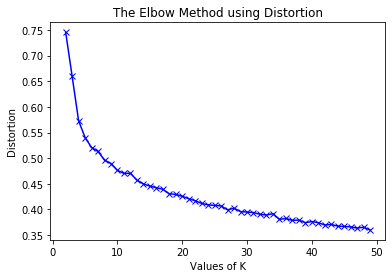

In [27]:
from sklearn.cluster import KMeans , DBSCAN
from sklearn import metrics 
from scipy.spatial.distance import cdist  
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(2,50) 
X = embeddings[vocab_size+max_doc_id:]
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()     


In [104]:
def kmeans(X, k):
    model_embeddings = X
    
    def count_elements(seq) :
        hist = {}
        for i in seq:
            hist[i] = hist.get(i, 0) + 1
        return hist

    kmeans = KMeans(n_clusters=k, random_state=0).fit(model_embeddings)

    clusters =kmeans.labels_
    return clusters


In [105]:
# plt.scatter(model_embeddings[clusters==0, 0], model_embeddings[clusters==0, 1], s=100, c='red', label ='Cluster 1')
# plt.scatter(model_embeddings[clusters==1, 0], model_embeddings[clusters==1, 1], s=100, c='blue', label ='Cluster 2')
# plt.scatter(model_embeddings[clusters==2, 0], model_embeddings[clusters==2, 1], s=100, c='green', label ='Cluster 3')
# plt.scatter(model_embeddings[clusters==3, 0], model_embeddings[clusters==3, 1], s=100, c='cyan', label ='Cluster 4')

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')

# plt.show()

In [106]:
# counts = count_elements(clusters)
# print('cluster distribution of the documents')
# for i in range(k):
#     print("count for cluster:",i, "is" ,counts[i])

In [107]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [108]:
def af_prop(X):
    af = AffinityPropagation(preference=-50).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_

    n_clusters_ = len(cluster_centers_indices)
    return labels, n_clusters_



In [109]:
def dbscan(X, ep):
#     ep = 1.9
    clustering = DBSCAN(eps=ep ,min_samples=5).fit(X)
    clusters =clustering.labels_
    unique, counts = np.unique(clusters, return_counts=True)

#     print (np.asarray((unique, counts)).T)

#     for i in range(max_doc_id):
#         if clusters[i] ==-1:
#             find_topic(i)
    return clusters

In [110]:
def spectralClustering(X,k):
    from sklearn.cluster import SpectralClustering
    clustering = SpectralClustering(n_clusters=k,assign_labels="discretize",random_state=0).fit(X)
    clusters = clustering.labels_
    unique, counts = np.unique(clusters, return_counts=True)

#     print (np.asarray((unique, counts)).T)

#     for i in range(max_doc_id):
#         if clusters[i] ==0:
#             find_topic(i)
    return clusters

In [132]:
# labels1, n_clusters_ = af_prop(X)
# labels2 = kmeans(X,7)
# labels3 = dbscan(X,2.31)
labels4 = spectralClustering(X,7)
# print("Affinity Propagation: Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels1, metric='sqeuclidean'))
# print("Kmeans: Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels2, metric='sqeuclidean'))
# print("DBScan: Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels3, metric='sqeuclidean'))
print("Spectral Clustering: Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels4, metric='sqeuclidean'))

Spectral Clustering: Silhouette Coefficient: 0.324


In [55]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))



In [136]:
clusters = spectralClustering(X,3)

In [137]:
from minisom import MiniSom
som = MiniSom(20, 20, 8, sigma= 1.6, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)
som.train_batch(X, 5000, verbose=True)

 [  389 / 5000 ]   8% - 0:00:02 left 

 [  932 / 5000 ]  19% - 0:00:01 left 

 [ 1588 / 5000 ]  32% - 0:00:01 left 

 [ 2248 / 5000 ]  45% - 0:00:00 left 

 [ 2831 / 5000 ]  57% - 0:00:00 left 

 [ 3481 / 5000 ]  70% - 0:00:00 left 

 [ 4138 / 5000 ]  83% - 0:00:00 left 

 [ 4800 / 5000 ]  96% - 0:00:00 left 

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3203868900485789


W1202 18:56:07.379380 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.380181 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.381501 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.382626 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.384416 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.385636 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.484503 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.485413 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.487462 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.488203 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.489911 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.490565 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.548446 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.549124 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.550810 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.551466 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.553087 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.553722 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.629035 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.629982 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.631601 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.632723 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.634105 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.634999 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.702916 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.704001 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.706728 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.707777 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.709696 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.710916 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.786336 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.787127 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.788893 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.789661 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.791481 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.792264 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.853354 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.854031 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.855476 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.856275 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.857745 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.858944 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:07.938067 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.939079 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.941640 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.947149 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.953446 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:07.954394 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.028127 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.028934 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.030824 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.031611 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.033601 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.034326 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.097038 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.097687 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.099351 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.100005 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.101634 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.102294 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.161779 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.162621 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.164046 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.165059 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.166576 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.167404 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.249376 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.250489 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.253122 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.254214 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.256891 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.258000 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.325824 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.327104 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.329536 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.330804 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.332565 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.335731 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.412274 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.413015 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.414871 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.416470 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.420847 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.422312 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.496225 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.497300 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.499790 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.500458 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.502421 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.503472 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:08.597914 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.600880 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.603736 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.605198 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.610100 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:08.612546 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W120

W1202 18:56:10.881598 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1202 18:56:10.882390 140184084436800 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


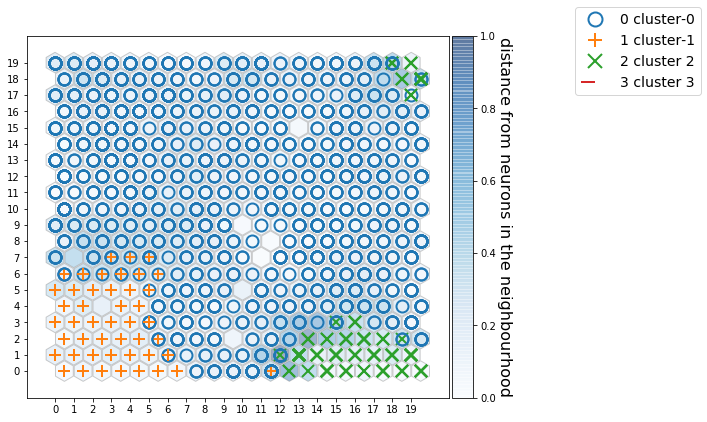

In [138]:


f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)

ax.set_aspect('equal')

xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        
        wy = yy[(i, j)]*2/np.sqrt(3)*3/4
        
        hex = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.95/np.sqrt(3),
                      facecolor=cm.Blues(umatrix[i, j]), alpha=.4, edgecolor='gray')
        ax.add_patch(hex)
markers = ['o', '+', 'x',0,'1','2','3','4','8',9,10,11,'s',2,3,4,5,6,7]
# colors = ['C0', 'C1', 'C2','C3']
# markers = ['o', '+', 'x','1','2','3','4','v','8','s']
colors = ['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9','C1', 'C2','C3','C4','C5','C6','C7','C8','C9']
for cnt, x in enumerate(X):
    w = som.winner(x)  # getting the winner
#     print(x)
    # palce a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy*2/np.sqrt(3)*3/4
#     print(wy,wx)
    plt.plot(wx, wy, marker= markers[clusters[cnt]], markerfacecolor='None', markeredgecolor=colors[clusters[cnt]], markersize=12, markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange*2/np.sqrt(3)*3/4, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='0 cluster-0',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='1 cluster-1',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='2 cluster 2',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker=0, color='C3', label='3 cluster 3',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
#                    Line2D([0], [0], marker='3', color='C5', label='5 cluster-10514',
#                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
#                    Line2D([0], [0], marker='4', color='C6', label='6 cluster-50',
#                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
#                    Line2D([0], [0], marker='v', color='C7', label='7 cluster-283',
#                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
#                    Line2D([0], [0], marker='8', color='C8', label='8 cluster-4',
#                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
#                    Line2D([0], [0], marker='s', color='C9', label='9 cluster-13',
#                    markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1.08), loc='upper left', 
          borderaxespad=0., ncol=1, fontsize=14)
# plt.legend()
plt.savefig('dbscan.eps')
plt.show()




In [59]:
def get_most_frequent(posts, topics):
    topic_author={}
    topic_author_count={}
    topic_post_count={}
    topic_post={}
    labels={}
    author_max_id = 0
    num_docs = len(topics.index) 
    max_doc_id = 0
    topic_name_id = {}
    for i, topic in topics.iterrows():
        
        if topic['mt_id'] in topic_post:
            topic_post[topic['mt_id']].append(clean_str(topic['mt_title']))
        else:
            topic_post[topic['mt_id']] = [clean_str(topic['mt_title'])]
        
    for i,post in posts.iterrows():
#         print(i,post)
        author_max_id = max(author_max_id, post['msg_author_id'])
        max_doc_id = max(max_doc_id , post['msg_topic_id'])
        if post['msg_topic_id'] in topic_author:
            topic_author[post['msg_topic_id']].append(post['msg_author_id'])
        else:
            topic_author[post['msg_topic_id']]= [post['msg_author_id']]
        if (post['msg_topic_id'],post['msg_author_id']) in topic_author_count:
            topic_author_count[(post['msg_topic_id'],post['msg_author_id'])] += 1
        else:
            topic_author_count[(post['msg_topic_id'],post['msg_author_id'])] = 1
        if post['msg_topic_id'] in topic_post_count:
            topic_post_count[post['msg_topic_id']] += 1
        else:
            topic_post_count[post['msg_topic_id']]  = 1
#         print(post["msg_topic_id"]) 
        if post['msg_topic_id'] in topic_post:
            topic_post[post['msg_topic_id']].append(clean_str(post['msg_post']))
        else:
            topic_post[post['msg_topic_id']] = [clean_str(post['msg_post'])]
#             topic_post[post['msg_topic_id']] = [post['msg_post']]
    topic_post_count.clear()
# ------------------------------
    word_freq = {}
    word_doc_list = {}
    word_set = set()
    for key in topic_post:
        appeared = set()
        topic_words = topic_post[key]
        for post_words in topic_words:
            words = post_words.split()
            for word in words:
                word_set.add(word)
                if word in word_freq:
                    word_freq[word] += 1
                else:
                    word_freq[word] = 1
                if word in appeared:
                    continue
                if word in word_doc_list:
                    word_doc_list[word].append(key)
                else:
                    word_doc_list[word] = [key]
                appeared.add(word)
    most_freq= [pair for pair in sorted(word_freq.items(), key=lambda item: item[1], reverse = True)]
    most_freq=most_freq[:100]
    return most_freq
    

In [60]:
most_freq = get_most_frequent(posts_2012, topics_2012)

In [61]:
print(most_freq)

[(',', 695), ('ipsquote', 294), ('data', 292), ('i', 227), ('\\?', 158), ('core', 95), ('\\)', 89), ('would', 80), ('div', 80), ('blockquote', 76), ('am', 75), ('span', 58), ('a', 50), ('get', 49), ('!', 49), ('it', 46), ('is', 46), ('you', 44), ('class', 42), ('like', 40), ('conversation', 39), ('contentapp', 38), ('contenttype', 38), ('messaging', 38), ('contentid', 38), ('contentclass', 38), ('messenger', 38), ('know', 38), ('emoticons', 38), ('style', 35), ('username', 35), ('well', 35), ('forum', 34), ('also', 33), ('cite', 33), ('timestamp', 33), ('one', 32), ('that', 32), ('have', 32), ('\\(', 32), ('think', 31), ('american', 31), ('dux', 29), ('could', 28), ('best', 27), ('post', 27), ('make', 27), ('the', 26), ('good', 26), ('will', 26), ('http', 26), ('new', 26), ('ben', 26), ('2', 25), ('thanks', 25), ('time', 25), ('going', 25), ('hello', 25), ('need', 25), ('com', 24), ('blackshirt', 24), ('see', 23), ('want', 23), ('png', 23), ('barton', 23), ('something', 22), ('me', 22)

In [ ]:
# node_size